In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import osmnx as ox
from rtree import index
from shapely.geometry import Point
import networkx as nx
import numpy as np

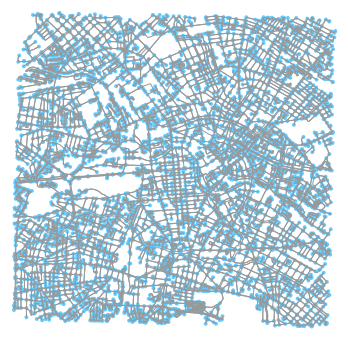

(<Figure size 431.686x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ed119d198>)

In [2]:
G = ox.graph_from_address('Berlin, Germany', distance=4000, network_type='bike')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [3]:
idx = index.Index()
for n_id, n in G_projected.nodes(data=True):
    idx.insert(int(n_id), (n['x'], n['y'], n['x'], n['y']))

In [4]:
def nearest_node(x, y):
    return list(idx.nearest((x, y, x, y), num_results=1))

In [5]:
def shortest_path_distance(G, source, target):
    path = nx.shortest_path(G, source=source, target=target)
    source = path[0]
    path = path[1:]
    target = path[0]
    print()
    path_length = 0
    while path:
        target = path[0]
        path = path[1:]
        path_length += G[source][target][0]['length']
        source = target
    return path_length

In [30]:
def plot_all(G, length=1000, fig_height=20, fig_width=None, margin=0.02, bounding_box=None):
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west bounds from bounding_box parameter or from the graph's geometries
    if bounding_box is None:
        edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    fig, ax = plt.subplots(figsize=(fig_height, fig_width), facecolor='white')
    
    # draw the edges as lines from node to node
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors='black', linewidths=1, alpha=0.9, zorder=2)
    ax.add_collection(lc)
    
    hit = int(np.random.choice(G_projected.nodes, size=1, replace=False)[0])
    n = G_projected.nodes(data=True)[hit]
    
    # create a circle around which we will form the random route
    center = Point(n['x'], n['y'])
    circle = center.buffer(length / 12)
    x,y = circle.exterior.xy

    ax.plot(x,y, 'r--')
    
    minx, miny, maxx, maxy = circle.envelope.bounds
    a = nearest_node(minx, miny)[0]
    b = nearest_node(minx, maxy)[0]
    c = nearest_node(maxx, maxy)[0]
    d = nearest_node(maxx, miny)[0]
    
    circle_total = 0
    # draw the four paths around the buffer
    for s, t, label, color in [[a, b, 'A', 'blue'], [b, c, 'B', 'green'], [c, d, 'C', 'yellow'], [d, a, 'D', 'red']]:
        # annotate the start node
        nd = G.nodes[s]
        xs, ys = nd['x'], nd['y']
        ax.annotate(label, xy=(xs, ys), zorder=10, color='red', size=20)
        
        # gather the total distance for the route around the circle
        circle_total += shortest_path_distance(G, s, t)
    
        path_lines = []
        try:
            path = nx.shortest_path(G, source=s, target=t)
        except:
            continue
        for i, v in enumerate(path):
            if i == 0:
                continue
            u = path[i-1]

            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            path_lines.append(line)
            
        lc = LineCollection(path_lines, colors=color, linewidths=4, alpha=0.9, zorder=5)
        ax.add_collection(lc)
    
    # get axis objects
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    # turn off the axis and ticks
    ax.axis('off')
    ax.margins(0)
    ax.tick_params(which='both', direction='in')
    xaxis.set_visible(False)
    yaxis.set_visible(False)
    ax.set_aspect('equal')
    fig.canvas.draw()
    
    plt.show()
    
    return a, b, c, d, circle_total

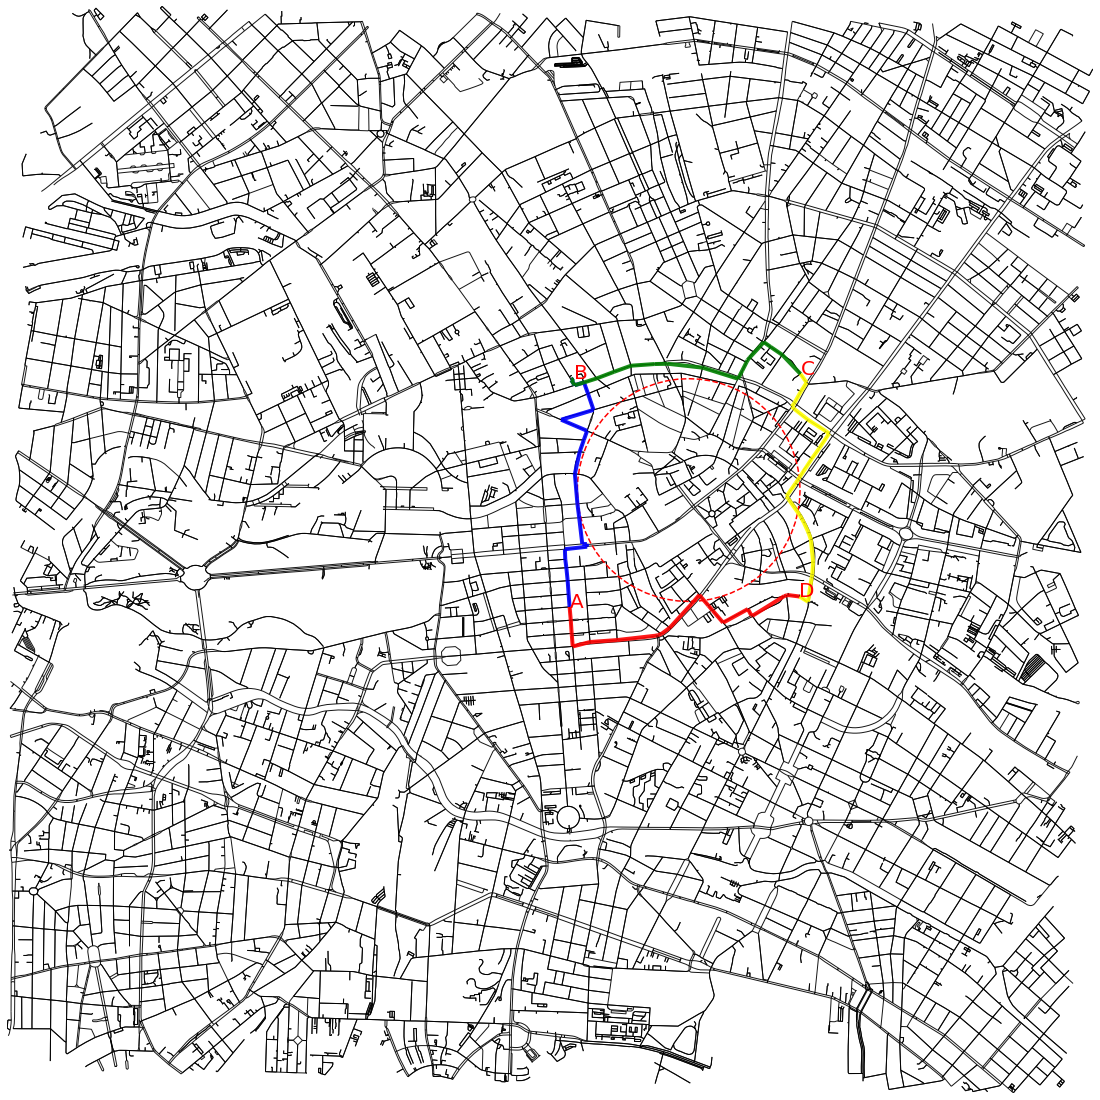

Route distance: 8.83 km


In [35]:
a, b, c, d, dist = plot_all(G_projected, length=10000)
print('Route distance: {0:1.2f} km'.format(dist/1000))